# Contoso Sales Analysis Assistant

## Objective

This notebook demonstrates the following:

<!-- - Function Calling with Yfinance to get latest stock prices. Summarization of user provided article. Extract country info from article, extract country, capital and other aspects, and call an API to get more information about each country.

This tutorial uses the following Azure AI services:
- Access to Azure OpenAI Service - you can apply for access [here](https://aka.ms/oai/access)
- Azure OpenAI service - you can create it from instructions [here](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/create-resource)
- Azure OpenAI Studio - go to [https://oai.azure.com/](https://oai.azure.com/) to work with the Assistants API Playground
- A connection to the Azure OpenAI Service with a [Key and Endpoint](https://learn.microsoft.com/en-us/azure/ai-services/openai/chatgpt-quickstart)

Reference:
- Learn more about how to use Assistants with our [How-to guide on Assistants](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/assistant)
- [Assistants OpenAI Overview](https://platform.openai.com/docs/assistants/overview) -->

## Time

You should expect to spend 10-15 minutes running this sample. 

## About this example

The objective of the provided Python file is to create an Azure OpenAI Assistant named "Contoso Sales Analysis Assistant" using the Azure OpenAI API. The assistant is designed to act as a sales analysis assistant, providing information and insights related to the contoso business sales. The script initiates a conversation with the assistant, guiding it through various financial queries and scenarios to showcase its capabilities.

### Data
This sample uses files from the folder [`data/`](./data/) in this repo. You can clone this repo or copy this folder to make sure you have access to these files when running the sample.



## Before you begin



### Installation

Create a Python Virtual Environment

#### Windows

1. Create a new Python virtual environment by running the following command in your terminal:

    ```bash
    python -m venv .venv
    ```

2. Activate the virtual environment:

    ```bash
    .venv\Scripts\activate
    ```

#### macOS and Linux

1. Create a new Python virtual environment by running the following command in your terminal:

    ```bash
    python3 -m venv .venv
    ```

2. Activate the virtual environment:

    ```bash
    source .venv/bin/activate
    ```

### Update pip

```bash
pip install --upgrade pip
```

Then, install the following packages required to execute this notebook. 



In [19]:
# Install the packages
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


### Parameters

In [20]:
import os
from dotenv import load_dotenv

load_dotenv(".env")
api_endpoint = os.getenv("OPENAI_URI")
api_key = os.getenv("OPENAI_KEY")
api_version = os.getenv("OPENAI_VERSION")
api_deployment_name = os.getenv("OPENAI_GPT_DEPLOYMENT")
email_URI = os.getenv("EMAIL_URI")

DATA_FOLDER = "data/"


assistant = None
thread = None
should_cleanup: bool = True

In [21]:
import io
import json
from datetime import datetime
from pathlib import Path
from typing import Iterable
from PIL import Image
from IPython.display import display

import yfinance as yf
from openai import AzureOpenAI
from openai.types import FileObject
from openai.types.beta.threads import Message, TextContentBlock, ImageFileContentBlock, Run
from openai.types.beta.thread import Thread

### Create an AzureOpenAI client

In [22]:
client = AzureOpenAI(api_key=api_key, api_version=api_version, azure_endpoint=api_endpoint)

### Get the latest stock price by ticker symbol using Yahoo Finance

In [23]:
def get_stock_price(symbol: str) -> str:
    stock = yf.Ticker(symbol)
    price = stock.history(period="1d")["Close"].iloc[-1]
    print(f"Current price for {symbol} is {price}")
    return str(price)

### Define the Assistant tools

In [24]:
tools_list = [
    {"type": "code_interpreter"},
    {
        "type": "function",
        "function": {
            "name": "get_stock_price",
            "description": "Retrieve the latest closing price of a stock using its ticker symbol.",
            "parameters": {
                "type": "object",
                "properties": {"symbol": {"type": "string", "description": "The ticker symbol of the stock"}},
                "required": ["symbol"],
            },
        },
    },
]

### Upload the file(s)

In [25]:



def upload_file(client: AzureOpenAI, path: str) -> FileObject:
    with Path(path).open("rb") as f:
        return client.files.create(file=f, purpose="assistants")

assistant_files = [upload_file(client, DATA_FOLDER + file) for file in os.listdir(DATA_FOLDER)]
file_ids = [file.id for file in assistant_files]

### Process Function calling

In [26]:
def call_functions(client: AzureOpenAI, thread: Thread, run: Run) -> None:
    print("Function Calling")
    required_actions = run.required_action.submit_tool_outputs.model_dump()
    print(required_actions)
    tool_outputs = []


    for action in required_actions["tool_calls"]:
        func_name = action["function"]["name"]
        arguments = json.loads(action["function"]["arguments"])

        if func_name == "get_stock_price":
            output = get_stock_price(symbol=arguments["symbol"])
            tool_outputs.append({"tool_call_id": action["id"], "output": output})
        else:
            raise ValueError(f"Unknown function: {func_name}")

    client.beta.threads.runs.submit_tool_outputs(thread_id=thread.id, run_id=run.id, tool_outputs=tool_outputs)

### Format and display the Assistant Messages for text and images

In [27]:
def format_messages(messages: Iterable[Message]) -> None:
    message_list = []
    message_list = [message for message in messages if message_list.append(message) or message.role != "user"]
    message_list.reverse()

    for message in message_list:
        for item in message.content:
            if isinstance(item, TextContentBlock):
                print(f"{message.role}:\n{item.text.value}\n")
            elif isinstance(item, ImageFileContentBlock):
                image = Image.open(io.BytesIO(client.files.content(item.image_file.file_id).read()))
                image = image.resize((image.width // 2, image.height // 2), Image.LANCZOS)
                display(image)

### Process the user messages

In [28]:
def process_message(content: str) -> None:
    client.beta.threads.messages.create(
        thread_id=thread.id, role="user", content=content
    )

    completed_run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id
    )
    
    print("processing starting")

    while True:
        completed_run = client.beta.threads.runs.poll(run_id=completed_run.id, thread_id=thread.id)
        print("Completed Run Status: " + completed_run.status)
        if completed_run.status == "completed":
            messages = client.beta.threads.messages.list(thread_id=thread.id)
            format_messages(messages)
            break
        elif completed_run.status == "requires_action":
            call_functions(client, thread, completed_run)
        elif completed_run.status in ["failed", "expired", "cancelled", "incomplete"]:
            messages = client.beta.threads.messages.list(thread_id=thread.id)
            format_messages(messages)
            break
    
    print("processing completed")

### Create an Assistant and a Thread

In [29]:
instructions = ("You are a personal securities trading assistant.",
                "Please be polite, professional, helpful, and friendly.", 
                "Use the provided stock portfolio CSV file to answer the questions.",
                "If question is not related to the stock portfolio or you cannot answer the question, ",
                "say, 'contact a representative for more assistance.' ", 
                "If the user asks for help or says 'help', provide a list of sample questions that you can answer.",
                f"The current date and time is: {datetime.now().strftime('%x %X')}.")

assistant = client.beta.assistants.create(
    name="Portfolio Management Assistant",
    model=api_deployment_name,
    instructions=str(instructions),
    tools=tools_list,
    tool_resources={"code_interpreter": {"file_ids": file_ids}},
)



### Create a thread

Threads in the OpenAI Assistant API are designed to be session-based.
Each thread is a conversation between the user and the assistant.

In [30]:
thread = client.beta.threads.create()

### Have a conversation with the Assistant

In [31]:
process_message("Based on the provided portfolio, what investments do I own? Include the average cost and the quantity of each investment. Display as a table")

processing starting
Completed Run Status: completed
assistant:
Here is the table displaying the investments you own, along with the average cost and the quantity for each investment:

| Symbol | Average Cost | Quantity |
|--------|--------------|----------|
| MSFT   | 200          | 300      |
| AAPL   | 114          | 200      |
| AMZN   | 125          | 50       |
| TSLA   | 900          | 100      |
| NFLX   | 540          | 80       |

If you have any further questions or need additional information, feel free to ask!

processing completed


In [33]:
process_message("display as a table how much each stock returned in dollars and percentage")

processing starting
Completed Run Status: requires_action
Function Calling
{'tool_calls': [{'id': 'call_COqCqBHFxZBsrfNsnhHXwklP', 'function': {'arguments': '{"symbol": "MSFT"}', 'name': 'get_stock_price'}, 'type': 'function'}, {'id': 'call_7YLCY934hiJgIsLXbB5o4LdE', 'function': {'arguments': '{"symbol": "AAPL"}', 'name': 'get_stock_price'}, 'type': 'function'}, {'id': 'call_ZlL9bR7h9uJjlRrVTgXs9w6n', 'function': {'arguments': '{"symbol": "AMZN"}', 'name': 'get_stock_price'}, 'type': 'function'}, {'id': 'call_irKlCYHDA4T7Bvlpv7NDXeCH', 'function': {'arguments': '{"symbol": "TSLA"}', 'name': 'get_stock_price'}, 'type': 'function'}, {'id': 'call_Aif3hBTPHXmEU2TZwquG6UYi', 'function': {'arguments': '{"symbol": "NFLX"}', 'name': 'get_stock_price'}, 'type': 'function'}]}
Current price for MSFT is 417.1099853515625
Current price for AAPL is 218.36000061035156
Current price for AMZN is 184.07000732421875
Current price for TSLA is 216.86000061035156
Current price for NFLX is 624.8499755859375


In [34]:
process_message("display as a table a detailed view of my portfolio")

processing starting
Completed Run Status: completed
assistant:
Here is the table displaying the investments you own, along with the average cost and the quantity for each investment:

| Symbol | Average Cost | Quantity |
|--------|--------------|----------|
| MSFT   | 200          | 300      |
| AAPL   | 114          | 200      |
| AMZN   | 125          | 50       |
| TSLA   | 900          | 100      |
| NFLX   | 540          | 80       |

If you have any further questions or need additional information, feel free to ask!

assistant:
Here is the table displaying how much each stock returned in dollars and percentage:

| Symbol | Return in Dollars | Return in Percentage |
|--------|-------------------|----------------------|
| MSFT   | $65,132.99        | 108.55%              |
| AAPL   | $20,872.00        | 91.54%               |
| AMZN   | $2,953.50         | 47.26%               |
| TSLA   | -$68,314.00       | -75.90%              |
| NFLX   | $6,787.99         | 15.71%             

processing starting
Completed Run Status: completed
assistant:
Here is the table displaying the investments you own, along with the average cost and the quantity for each investment:

| Symbol | Average Cost | Quantity |
|--------|--------------|----------|
| MSFT   | 200          | 300      |
| AAPL   | 114          | 200      |
| AMZN   | 125          | 50       |
| TSLA   | 900          | 100      |
| NFLX   | 540          | 80       |

If you have any further questions or need additional information, feel free to ask!

assistant:
Here is the table displaying how much each stock returned in dollars and percentage:

| Symbol | Return in Dollars | Return in Percentage |
|--------|-------------------|----------------------|
| MSFT   | $65,132.99        | 108.55%              |
| AAPL   | $20,872.00        | 91.54%               |
| AMZN   | $2,953.50         | 47.26%               |
| TSLA   | -$68,314.00       | -75.90%              |
| NFLX   | $6,787.99         | 15.71%             

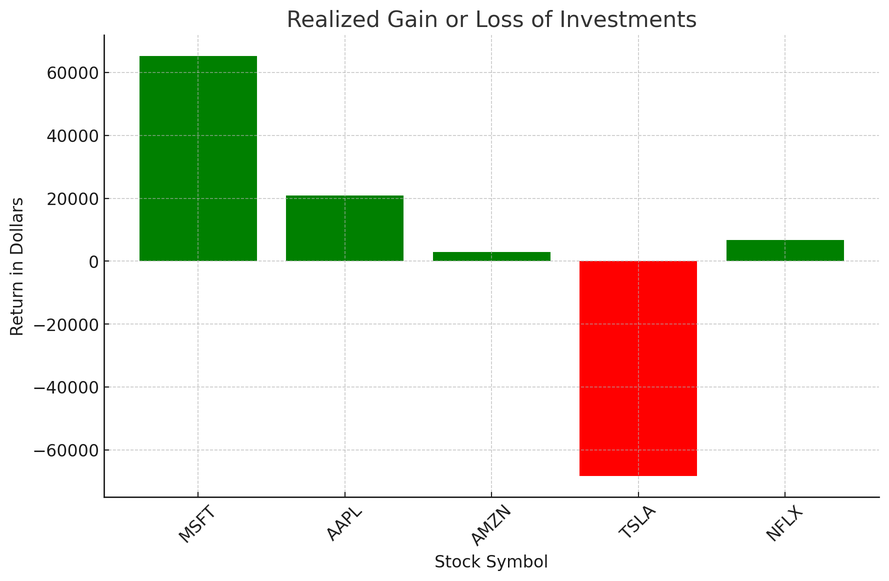

assistant:
Here is the chart displaying the realized gain or loss of your investments:

Each bar represents the return in dollars for each stock in your portfolio. The green bars indicate a gain, while the red bar indicates a loss.

If you have any further questions or need additional information, feel free to ask!

processing completed


In [35]:
process_message("Chart the realized gain or loss of my investments.")

## Cleaning up

In [36]:
if should_cleanup:
    client.beta.assistants.delete(assistant.id)
    client.beta.threads.delete(thread.id)
    for file in assistant_files:
        client.files.delete(file.id)